In [1]:
import sys,os
sys.path.append('../')
sys.path.append('./')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
!mkdir log

import sys,os
sys.path.append('')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

mkdir: log: File exists
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Layout preparation

In [2]:
import pickle

layout = '4rooms'

def store_agent(obj, agent_name, layout=layout):
  print('storing network')
  pickle.dump(obj, open('./agent/'+agent_name+ '.p', 'wb'))

def load_agent(agent_name):
  filename = agent_name + '.p'
  return pickle.load(open('./agent/'+filename, 'rb'))

if layout == '3rooms' or layout == '3roomsh':
    cell_num = 101
    max_step_dqn = 1e5
    linear_schedule_dqn = 6e4
elif layout == 'maze':
  cell_num = 75
  max_step_dqn = 1.5e5
  linear_schedule_dqn = 9e4
else:
    cell_num = 104
    max_step_dqn = 7e4
    linear_schedule_dqn = 4e4
    
    max_step_avdsr_A = 3e5
    linear_schedule_avdsr_A = 3e4
    
    max_step_avdsr_B = 1e5
    linear_schedule_avdsr_B = 1e4
    
    max_step_dsr = 7e4
    linear_schedule_dsr = 4e4
    
    learning_rate_dqn = 2e-3
    learning_rate_avdsr = 2e-3
    learning_rate_dsr = 1e-3

In [4]:
learning_rate_dqn = 2e-3 #from 0.05 - 0.001

def dqn_feature(goal = 0, **kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.DEVICE = torch.device('cuda:1')
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dqn)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dqn)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dqn
    config.async_actor = False
    agent = DQNAgent(config)

    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    # agent.step()
    # plt.figure(figsize=(10,4))
    try : 
        agent.network = load_agent(f'DQN-goal={goal}-layout={layout}')
    except:
        while True:
        # print(agent.actor._task.env.envs[0].goal)
            if config.save_interval and not agent.total_steps % config.save_interval:
                agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
            if config.log_interval and not agent.total_steps % config.log_interval:
                t0 = time.time()
            if config.eval_interval and not agent.total_steps % config.eval_interval:
                agent.eval_episodes()
                pass
            if config.max_steps and agent.total_steps >= config.max_steps:
                store_agent(agent.network, f'DQN-goal={goal}-layout={layout}')
                return agent
                break
            agent.step()
          # plt.title('step: {}'.format(agent.total_steps), fontsize=20)
          # plt.imshow(agent.actor._task.env.envs[0].render(), cmap='Blues', )
            agent.switch_task()
    return agent

def avdsr_feature_A(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_avdsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, linear_schedule_avdsr_A) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = max_step_avdsr_A
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    # agent.network = load_agent('avdsr-A')
    try:
        agent.network.load_state_dict(load_agent('avdsr-A-'+config.game).state_dict)
    except:  
        while True:
            if config.log_interval and not agent.total_steps % config.log_interval:
                agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
                t0 = time.time()
            if config.max_steps and agent.total_steps >= config.max_steps:
                store_agent(agent.network, 'avdsr-A-'+config.game)
                return agent
                break
        #         import pdb; pdb.set_trace()
            agent.step()
            agent.switch_task()
      
    
def avdsr_feature_B(ref=None, **kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_avdsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(), config=0) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.5, 0.5, linear_schedule_avdsr_B) # CHECK what proportion of time we want the agent to explore or follow the trained policy
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = max_step_avdsr_B
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    if ref :
        agent.network.load_state_dict(ref.network.state_dict())
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
        
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dsr)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dsr
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

In [7]:
goal1 = str(random.randint(0, cell_num))
goal2 = str(random.randint(0, cell_num))
goal3 = str(random.randint(0, cell_num))
goal4 = str(random.randint(0, cell_num))
goal5 = str(random.randint(0, cell_num))

goal1 = str(1)
goal2 = str(20)
goal3 = str(40)
goal4 = str(60)
goal5 = str(80)

p1 = dqn_feature(goal=goal1, game='FourRoomsMatrix-Goal-'+goal1)
p2 = dqn_feature(goal=goal2, game='FourRoomsMatrix-Goal-'+goal2)
p3 = dqn_feature(goal=goal3, game='FourRoomsMatrix-Goal-'+goal3)
p4 = dqn_feature(goal=goal4, game='FourRoomsMatrix-Goal-'+goal4)
p5 = dqn_feature(goal=goal5, game='FourRoomsMatrix-Goal-'+goal5)

In [8]:
p1.actor._task.env.envs[0]

<OriginalReturnWrapper<FourRoomsMatrix instance>>

In [9]:
avdsr = avdsr_feature_A(game='Dy-FourRoomsMatrixNoTerm', agents=[p1], choice=0)

2021-03-22 00:32:03,951 - root - INFO: steps 0, 259468.23 steps/s


<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>


2021-03-22 00:32:04,903 - root - INFO: steps 1000, 1057.94 steps/s
2021-03-22 00:32:05,630 - root - INFO: steps 2000, 1378.85 steps/s
2021-03-22 00:32:06,396 - root - INFO: steps 3000, 1309.39 steps/s
2021-03-22 00:32:07,129 - root - INFO: steps 4000, 1367.18 steps/s


KeyboardInterrupt: 

In [28]:
SR_set = []
SR_set.append(avdsr_feature_B(ref = avdsr, game='FourRoomsMatrixNoTerm', agents=[p1], choice=0))
SR_set.append(avdsr_feature_B(ref = avdsr, game='FourRoomsMatrixNoTerm', agents=[p2], choice=0))
SR_set.append(avdsr_feature_B(ref = avdsr, game='FourRoomsMatrixNoTerm', agents=[p3], choice=0))
SR_set.append(avdsr_feature_B(ref = avdsr, game='FourRoomsMatrixNoTerm', agents=[p4], choice=0))
SR_set.append(avdsr_feature_B(ref = avdsr, game='FourRoomsMatrixNoTerm', agents=[p5], choice=0))



2021-03-20 02:14:35,748 - root - INFO: steps 0, 524288000.00 steps/s


<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>


2021-03-20 02:14:36,449 - root - INFO: steps 1000, 1431.56 steps/s
2021-03-20 02:14:37,112 - root - INFO: steps 2000, 1512.25 steps/s
2021-03-20 02:14:37,763 - root - INFO: steps 3000, 1539.29 steps/s
2021-03-20 02:14:38,425 - root - INFO: steps 4000, 1513.37 steps/s
2021-03-20 02:14:39,140 - root - INFO: steps 5000, 1401.87 steps/s
2021-03-20 02:14:39,855 - root - INFO: steps 6000, 1402.32 steps/s
2021-03-20 02:14:40,570 - root - INFO: steps 7000, 1402.28 steps/s
2021-03-20 02:14:41,262 - root - INFO: steps 8000, 1449.29 steps/s
2021-03-20 02:14:41,941 - root - INFO: steps 9000, 1475.77 steps/s
2021-03-20 02:14:42,635 - root - INFO: steps 10000, 1445.29 steps/s
2021-03-20 02:14:43,346 - root - INFO: steps 11000, 1409.15 steps/s
2021-03-20 02:14:44,039 - root - INFO: steps 12000, 1447.39 steps/s
2021-03-20 02:14:44,704 - root - INFO: steps 13000, 1505.70 steps/s
2021-03-20 02:14:45,437 - root - INFO: steps 14000, 1368.04 steps/s
2021-03-20 02:14:46,145 - root - INFO: steps 15000, 1414.

<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>


2021-03-20 02:15:57,475 - root - INFO: steps 1000, 1411.71 steps/s
2021-03-20 02:15:58,167 - root - INFO: steps 2000, 1450.96 steps/s
2021-03-20 02:15:58,864 - root - INFO: steps 3000, 1438.52 steps/s
2021-03-20 02:15:59,548 - root - INFO: steps 4000, 1465.72 steps/s
2021-03-20 02:16:00,283 - root - INFO: steps 5000, 1364.23 steps/s
2021-03-20 02:16:01,046 - root - INFO: steps 6000, 1313.45 steps/s
2021-03-20 02:16:01,788 - root - INFO: steps 7000, 1351.69 steps/s
2021-03-20 02:16:02,520 - root - INFO: steps 8000, 1367.35 steps/s
2021-03-20 02:16:03,202 - root - INFO: steps 9000, 1469.99 steps/s
2021-03-20 02:16:03,891 - root - INFO: steps 10000, 1455.70 steps/s
2021-03-20 02:16:04,597 - root - INFO: steps 11000, 1419.59 steps/s
2021-03-20 02:16:05,298 - root - INFO: steps 12000, 1433.61 steps/s
2021-03-20 02:16:05,993 - root - INFO: steps 13000, 1443.01 steps/s
2021-03-20 02:16:06,708 - root - INFO: steps 14000, 1401.28 steps/s
2021-03-20 02:16:07,412 - root - INFO: steps 15000, 1425.

<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>


2021-03-20 02:17:12,586 - root - INFO: steps 1000, 1251.84 steps/s
2021-03-20 02:17:13,387 - root - INFO: steps 2000, 1250.05 steps/s
2021-03-20 02:17:14,169 - root - INFO: steps 3000, 1282.62 steps/s
2021-03-20 02:17:14,951 - root - INFO: steps 4000, 1280.68 steps/s
2021-03-20 02:17:15,742 - root - INFO: steps 5000, 1267.79 steps/s
2021-03-20 02:17:16,523 - root - INFO: steps 6000, 1283.08 steps/s
2021-03-20 02:17:17,288 - root - INFO: steps 7000, 1310.86 steps/s
2021-03-20 02:17:18,052 - root - INFO: steps 8000, 1311.15 steps/s
2021-03-20 02:17:18,808 - root - INFO: steps 9000, 1327.21 steps/s
2021-03-20 02:17:19,561 - root - INFO: steps 10000, 1331.01 steps/s
2021-03-20 02:17:20,349 - root - INFO: steps 11000, 1271.45 steps/s
2021-03-20 02:17:21,127 - root - INFO: steps 12000, 1303.50 steps/s
2021-03-20 02:17:21,887 - root - INFO: steps 13000, 1319.64 steps/s
2021-03-20 02:17:22,653 - root - INFO: steps 14000, 1309.86 steps/s
2021-03-20 02:17:23,408 - root - INFO: steps 15000, 1327.

<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>


2021-03-20 02:18:29,187 - root - INFO: steps 1000, 1395.36 steps/s
2021-03-20 02:18:29,920 - root - INFO: steps 2000, 1367.56 steps/s
2021-03-20 02:18:30,649 - root - INFO: steps 3000, 1374.10 steps/s
2021-03-20 02:18:31,364 - root - INFO: steps 4000, 1402.13 steps/s
2021-03-20 02:18:32,101 - root - INFO: steps 5000, 1360.91 steps/s
2021-03-20 02:18:32,843 - root - INFO: steps 6000, 1351.02 steps/s
2021-03-20 02:18:33,612 - root - INFO: steps 7000, 1302.04 steps/s
2021-03-20 02:18:34,334 - root - INFO: steps 8000, 1393.03 steps/s
2021-03-20 02:18:35,058 - root - INFO: steps 9000, 1386.16 steps/s
2021-03-20 02:18:35,788 - root - INFO: steps 10000, 1372.92 steps/s
2021-03-20 02:18:36,523 - root - INFO: steps 11000, 1364.25 steps/s
2021-03-20 02:18:37,244 - root - INFO: steps 12000, 1389.99 steps/s
2021-03-20 02:18:37,962 - root - INFO: steps 13000, 1397.07 steps/s
2021-03-20 02:18:38,686 - root - INFO: steps 14000, 1383.82 steps/s
2021-03-20 02:18:39,434 - root - INFO: steps 15000, 1340.

<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>


2021-03-20 02:19:43,980 - root - INFO: steps 1000, 1358.01 steps/s
2021-03-20 02:19:44,730 - root - INFO: steps 2000, 1334.86 steps/s
2021-03-20 02:19:45,477 - root - INFO: steps 3000, 1341.76 steps/s
2021-03-20 02:19:46,256 - root - INFO: steps 4000, 1287.56 steps/s
2021-03-20 02:19:47,000 - root - INFO: steps 5000, 1351.78 steps/s
2021-03-20 02:19:47,794 - root - INFO: steps 6000, 1262.46 steps/s
2021-03-20 02:19:48,530 - root - INFO: steps 7000, 1361.53 steps/s
2021-03-20 02:19:49,261 - root - INFO: steps 8000, 1370.83 steps/s
2021-03-20 02:19:50,013 - root - INFO: steps 9000, 1333.37 steps/s
2021-03-20 02:19:50,793 - root - INFO: steps 10000, 1285.83 steps/s
2021-03-20 02:19:51,535 - root - INFO: steps 11000, 1349.87 steps/s
2021-03-20 02:19:52,270 - root - INFO: steps 12000, 1364.87 steps/s
2021-03-20 02:19:53,037 - root - INFO: steps 13000, 1306.79 steps/s
2021-03-20 02:19:53,800 - root - INFO: steps 14000, 1312.95 steps/s
2021-03-20 02:19:54,565 - root - INFO: steps 15000, 1310.

In [17]:
random_psi = avdsr_feature_A(game='FourRoomsMatrixNoTerm', agents=[p1], choice=0)
target = dsr_feature_init(game='FourRoomsMatrix-Goal-62', freeze=2, ref=random_psi, style=0)

2021-03-20 01:59:18,771 - root - INFO: steps 0, 753558.03 steps/s


<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>


2021-03-20 01:59:19,570 - root - INFO: steps 1000, 1259.36 steps/s
2021-03-20 01:59:20,298 - root - INFO: steps 2000, 1377.48 steps/s
2021-03-20 01:59:20,972 - root - INFO: steps 3000, 1485.97 steps/s
2021-03-20 01:59:21,724 - root - INFO: steps 4000, 1331.98 steps/s
2021-03-20 01:59:22,454 - root - INFO: steps 5000, 1373.91 steps/s
2021-03-20 01:59:23,107 - root - INFO: steps 6000, 1535.56 steps/s
2021-03-20 01:59:23,759 - root - INFO: steps 7000, 1536.36 steps/s
2021-03-20 01:59:24,427 - root - INFO: steps 8000, 1500.40 steps/s
2021-03-20 01:59:25,174 - root - INFO: steps 9000, 1340.91 steps/s
2021-03-20 01:59:25,835 - root - INFO: steps 10000, 1519.29 steps/s
2021-03-20 01:59:26,497 - root - INFO: steps 11000, 1513.97 steps/s
2021-03-20 01:59:27,164 - root - INFO: steps 12000, 1503.02 steps/s
2021-03-20 01:59:27,884 - root - INFO: steps 13000, 1392.99 steps/s
2021-03-20 01:59:28,560 - root - INFO: steps 14000, 1483.47 steps/s
2021-03-20 01:59:29,294 - root - INFO: steps 15000, 1365.

storing network
<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>
<All keys matched successfully>


2021-03-20 02:02:52,981 - root - INFO: steps 0, episodic_return_test -180.00(18.97)
2021-03-20 02:03:01,341 - root - INFO: steps 5000, episodic_return_test -120.80(30.68)
2021-03-20 02:03:04,753 - root - INFO: steps 10000, episodic_return_test -43.60(24.74)
2021-03-20 02:03:08,139 - root - INFO: steps 15000, episodic_return_test -24.50(18.51)
2021-03-20 02:03:11,496 - root - INFO: steps 20000, episodic_return_test -5.30(0.91)
2021-03-20 02:03:15,135 - root - INFO: steps 25000, episodic_return_test -6.30(0.88)
2021-03-20 02:03:18,705 - root - INFO: steps 30000, episodic_return_test -8.80(0.85)
2021-03-20 02:03:22,238 - root - INFO: steps 35000, episodic_return_test -22.90(18.68)
2021-03-20 02:03:25,601 - root - INFO: steps 40000, episodic_return_test -7.00(0.87)
2021-03-20 02:03:28,928 - root - INFO: steps 45000, episodic_return_test -7.40(1.24)
2021-03-20 02:03:32,364 - root - INFO: steps 50000, episodic_return_test -5.50(1.12)
2021-03-20 02:03:35,854 - root - INFO: steps 55000, episod

In [44]:
from deep_rl.agent.GPI_agent import *
# import fourrooms

# def runNAgents(function, runs, store=True, freeze=0, ref=None, style=0, agents=None, target=None):
#     r_dqn = []; t_dqn = []
#     if(store):
#         agents = []
#     for i in range(runs): 
#         agent = function(game='FourRoomsMatrix', freeze=freeze, ref=ref, style=style, agents=agents, target=target)
#         rewards = np.array(agent.returns)
#         t_dqn.append(rewards[:,0])
#         r_dqn.append(rewards[:,1])
#         if(store):
#             agents.append(agent)
            
#     if(store):
#         return agents, t_dqn, r_dqn
    
#     return t_dqn, r_dqn


# def plot_rewards(rewards, plot_seperate=True , clip=clip, title='unnamed'):
    
#     colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
#     plt.figure(figsize=(16,6), dpi=200)
#     if(plot_seperate):
#         for k, v in rewards.items():
#             for t, r in zip(v[0], v[1]):
#                 plt.plot(t, r, label=k)
#         plt.legend(), plt.show()
#         return
    
#     for j, (k, v) in enumerate(rewards.items()):
#         r_vec = np.zeros((len(v[0]), clip-smooth+1))
#         for i, (t, r) in enumerate(zip(v[0], v[1])):
#             r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
#         mean = np.mean(np.array(r_vec), axis=0)
#         std = np.std(np.array(r_vec), axis=0)
#         plt.plot(mean, label=k, color=colors[j])
#         plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
#     plt.xlabel('timesteps'), plt.ylabel('episodic returns')
#     plt.title(title)
#     plt.legend(loc='lower right'), plt.show()


def gpi_feature(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_dsr)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), config=config.style)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.1, 0.1, linear_schedule_dsr)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dsr
    config.async_actor = False
    
    agent = GPIAgent(config, agents=SR_set, target=target,)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval: 
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        # agent.eval_episodes()
        # time.sleep(0.2)
        agent.step()
        # agent.actor._task.env.render()
        # time.sleep(0.2)
        agent.switch_task()
    # agent.step()
    return agent


GPI = gpi_feature(game='FourRoomsMatrix-Goal-62', freeze=2, ref=None, style=0)

(169,)


2021-03-21 13:30:02,272 - root - INFO: steps 0, episodic_return_test -5.30(1.18)


(169,)
<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>
<class 'deep_rl.network.network_heads.SRNet'>


2021-03-21 13:30:06,716 - root - INFO: steps 5000, episodic_return_test -45.40(24.46)


KeyboardInterrupt: 

In [43]:
p.step()

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  1  0  1  1 -1  1  1  1  1  1 -1]
 [-1  1  3  1  1  1 -1  1  1  1  1  1 -1]
 [-1  3  3  3  3  3  3  1  1  1  1  2 -1]
 [-1  0  0  0  3  0 -1  3  3  1  1  1 -1]
 [-1  0  0  0  0  0 -1  3  3  1  2  2 -1]
 [-1 -1  0 -1 -1 -1 -1  3  3  1  2  2 -1]
 [-1  0  1  0  0  0 -1 -1 -1 10 -1 -1 -1]
 [-1  2  1  1  1  1 -1  3  3  0  2  2 -1]
 [-1  1  1  1  1  1 -1  3  3  0  0  2 -1]
 [-1  3  3  3  3  3  3  3  0  0  2  2 -1]
 [-1  3  0  0  0  0 -1  3  0  0  2  2 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


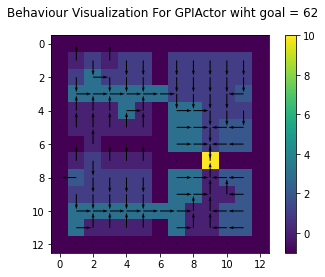

In [41]:
GPI.mapping()
# dqn.actor._state
# plt.figure()
# plt.imshow(np.array(dqn.actor._state).reshape([13, 13]))

In [ ]:
goal1 = str(random.randint(0, cell_num))
goal2 = str(random.randint(0, cell_num))
goal3 = str(random.randint(0, cell_num))
goal4 = str(random.randint(0, cell_num))
goal5 = str(random.randint(0, cell_num))

# goal1 = str(44)
# goal2 = str(82)
# goal3 = str(80)

p1 = dqn_feature(goal=goal1, game='FourRoomsMatrix-Goal-'+goal1)
p2 = dqn_feature(goal=goal2, game='FourRoomsMatrix-Goal-'+goal2)
p3 = dqn_feature(goal=goal3, game='FourRoomsMatrix-Goal-'+goal3)
p4 = dqn_feature(goal=goal4, game='FourRoomsMatrix-Goal-'+goal4)
p5 = dqn_feature(goal=goal5, game='FourRoomsMatrix-Goal-'+goal5)